In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score
from tensorflow.keras.preprocessing.text import Tokenizer
from keras import Sequential, Input, callbacks, metrics, preprocessing, utils, layers, optimizers, losses

In [2]:
# Load and preprocess data
data = pd.read_csv(r"/kaggle/input/benign-and-malicious-urls/balanced_urls.csv")
data = data.sample(frac=1, random_state=123).reset_index(drop=True)
data.head()

,url,label,result
0,https://sites.google.com/site/chekconfrmacount...,malicious,1
1,http://dealerjoin.com/78hceef,malicious,1
2,https://www.facebook.com/pages/Birks-Mayors/10...,benign,0
3,https://soortv.com/mJG5cU4H2sPS3ld/2iiZWIoW36p...,malicious,1
4,https://www.facebook.com/pages/The-Boat-That-R...,benign,0


In [3]:
data.value_counts("result")

result
0    316254
1    316254
Name: count, dtype: int64

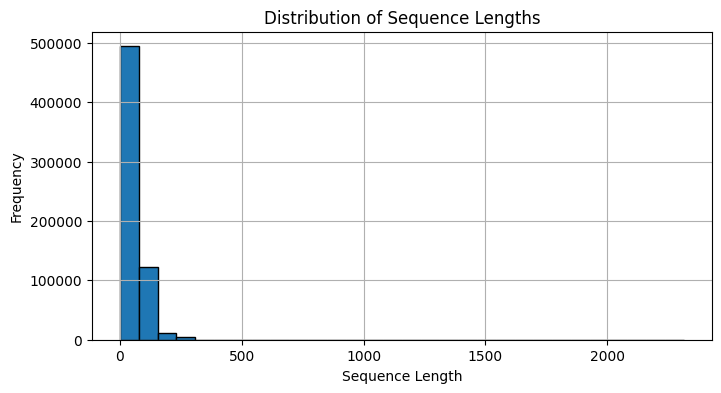

In [4]:
# Get features and labels
urls = data["url"].values
labels = data["result"].values

# Tokenize the URLs at the character level
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(urls)
sequences = tokenizer.texts_to_sequences(urls)

# Calculate the lengths of the sequences
sequence_lengths = [len(seq) for seq in sequences]

# Plot the lengths using a histogram
plt.figure(figsize=(8, 4))
plt.hist(sequence_lengths, bins=30, edgecolor='black')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [5]:
# Pad the sequences to ensure uniform length
max_sequence_length = 300
X = preprocessing.sequence.pad_sequences(sequences, maxlen=max_sequence_length)
y = labels

# Split the data into training and validation sets
xtrain, xval, ytrain, yval = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=123,
    stratify=y,
)

# Set parameters for the embedding layer
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding token
embedding_dim = 50

In [6]:
# Build the Conv1D net
utils.set_random_seed(123)
net = Sequential([
    Input(shape=(max_sequence_length,)),
    
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    
    layers.Conv1D(filters=128, kernel_size=5),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Conv1D(filters=64, kernel_size=5),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling1D(pool_size=2),
    
    layers.GlobalMaxPooling1D(),
    
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    layers.Dense(1, activation='sigmoid')
])

net.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 50)        │        14,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 296, 128)       │        32,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 296, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 296, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 148, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 144, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 144, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 144, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 72, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,051 (363.48 KB)

 Trainable params: 92,539 (361.48 KB)

 Non-trainable params: 512 (2.00 KB)

In [7]:
# Set early stopping to avoid overfitting
early_stopping = callbacks.EarlyStopping(
    monitor="val_f1_score",
    mode="max",
    patience=9,
    restore_best_weights=True,
)

# Set up a ModelCheckpoint to save the best model
checkpoint = callbacks.ModelCheckpoint(
    "net1.keras",
    monitor="val_f1_score",
    save_best_only=True,
    mode="max",
    verbose=1,
)

# Custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = metrics.Precision()
        self.recall = metrics.Recall()
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update precision and recall states
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Get precision and recall
        precision = self.precision.result()
        recall = self.recall.result()
        # Calculate F1 score
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()
    
    def get_config(self):
        # Return the configuration of the metric
        config = super(F1Score, self).get_config()
        return config

In [8]:
# Compile the net with binary crossentropy loss, and track precision and recall
utils.set_random_seed(123)
learning_rate = 0.00001
net.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss=losses.BinaryCrossentropy(from_logits=False),
    metrics=[
        metrics.BinaryAccuracy(threshold=0.5, name="accuracy"),
        metrics.Precision(name="precision"),
        metrics.Recall(name="recall"),
        F1Score(name="f1_score")
    ],
)

# Train the net
history = net.fit(
    xtrain,
    ytrain,
    validation_data=(xval, yval),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, checkpoint],
)

Epoch 1/100


I0000 00:00:1726545115.576464      80 service.cc:145] XLA service 0x7a8eec011ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726545115.576532      80 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   33/15813 ━━━━━━━━━━━━━━━━━━━━ 1:16 5ms/step - accuracy: 0.4857 - f1_score: 0.4514 - loss: 0.8499 - precision: 0.4927 - recall: 0.4176

I0000 00:00:1726545119.750379      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15813/15813 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9421 - f1_score: 0.9393 - loss: 0.1567 - precision: 0.9604 - recall: 0.9198
Epoch 1: val_f1_score improved from -inf to 0.99610, saving model to net1.keras
15813/15813 ━━━━━━━━━━━━━━━━━━━━ 92s 5ms/step - accuracy: 0.9421 - f1_score: 0.9393 - loss: 0.1567 - precision: 0.9604 - recall: 0.9198 - val_accuracy: 0.9961 - val_f1_score: 0.9961 - val_loss: 0.0199 - val_precision: 0.9975 - val_recall: 0.9947
Epoch 2/100
15806/15813 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9961 - f1_score: 0.9961 - loss: 0.0235 - precision: 0.9976 - recall: 0.9947
Epoch 2: val_f1_score improved from 0.99610 to 0.99630, saving model to net1.keras
15813/15813 ━━━━━━━━━━━━━━━━━━━━ 80s 5ms/step - accuracy: 0.9961 - f1_score: 0.9961 - loss: 0.0235 - precision: 0.9976 - recall: 0.9947 - val_accuracy: 0.9963 - val_f1_score: 0.9963 - val_loss: 0.0167 - val_precision: 0.9975 - val_recall: 0.9951
Epoch 3/100
15803/15813 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

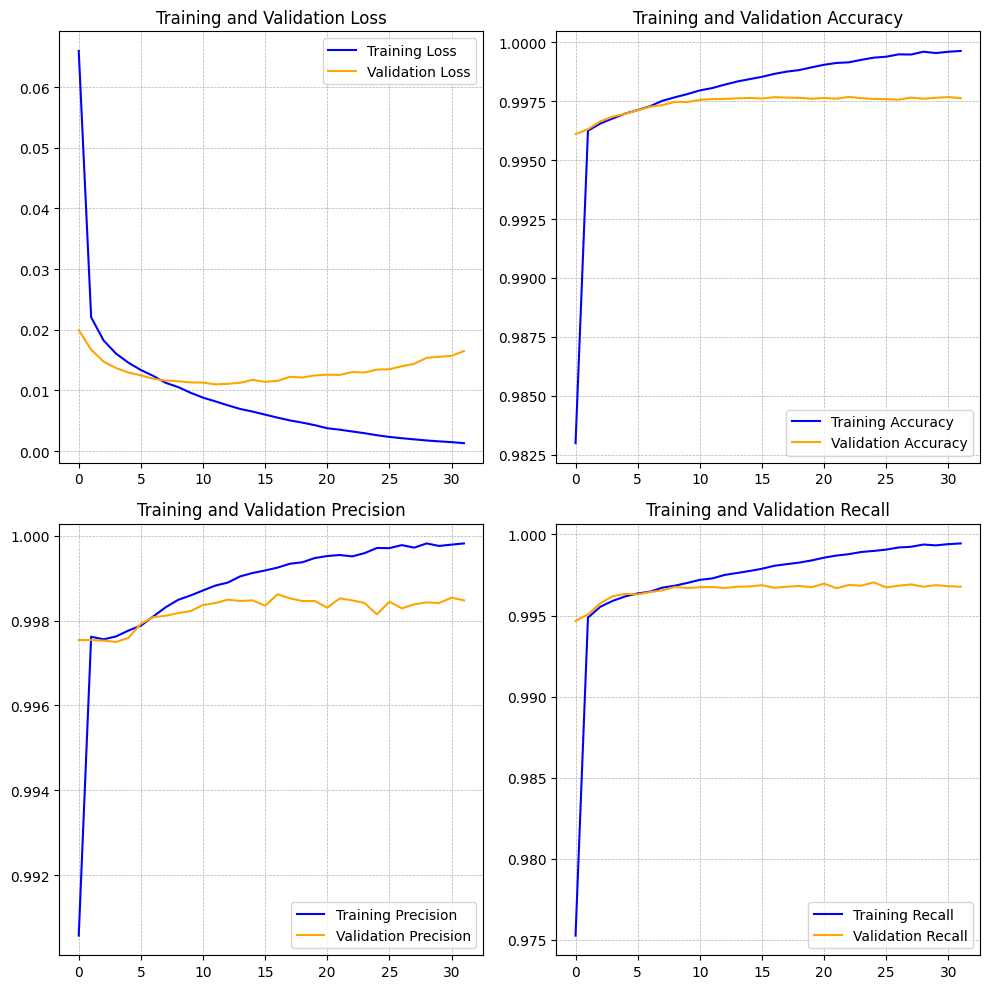

In [9]:
# Retrieve Precision and Recall values from the history
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_precision = history.history["precision"]
val_precision = history.history["val_precision"]
train_recall = history.history["recall"]
val_recall = history.history["val_recall"]

# Get the number of epochs
epochs_range = range(len(train_loss))

# Plot Training and Validation Loss
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_loss, label="Training Loss", color="blue")
plt.plot(epochs_range, val_loss, label="Validation Loss", color="orange")
plt.legend(loc="upper right")
plt.grid(True, lw=0.5, linestyle="--")
plt.title("Training and Validation Loss")

# Plot Training and Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_acc, label="Training Accuracy", color="blue")
plt.plot(epochs_range, val_acc, label="Validation Accuracy", color="orange")
plt.legend(loc="lower right")
plt.grid(True, lw=0.5, linestyle="--")
plt.title("Training and Validation Accuracy")

# Plot Training and Validation Precision
plt.subplot(2, 2, 3)
plt.plot(epochs_range, train_precision, label="Training Precision", color="blue")
plt.plot(epochs_range, val_precision, label="Validation Precision", color="orange")
plt.legend(loc="lower right")
plt.grid(True, lw=0.5, linestyle="--")
plt.title("Training and Validation Precision")

# Plot Training and Validation Recall
plt.subplot(2, 2, 4)
plt.plot(epochs_range, train_recall, label="Training Recall", color="blue")
plt.plot(epochs_range, val_recall, label="Validation Recall", color="orange")
plt.legend(loc="lower right")
plt.grid(True, lw=0.5, linestyle="--")
plt.title("Training and Validation Recall")

# Save the figure and display
plt.tight_layout()
plt.savefig("metrics.png")
plt.show()

3954/3954 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Recall at threshold 0.1: 0.9975
Precision at threshold 0.1: 0.9972


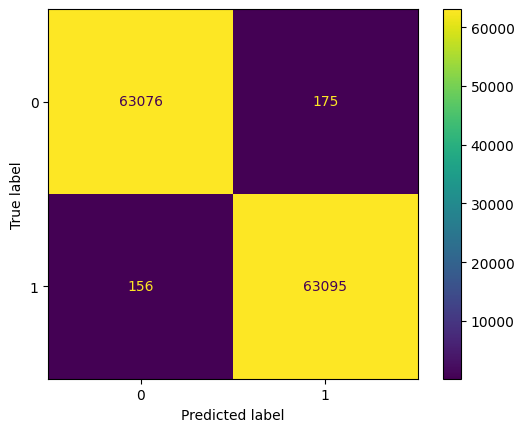

In [14]:
threshold = 0.1
y_pred_prob = net.predict(xval)
y_pred_thresholded = (y_pred_prob > threshold).astype("int32")
recall = recall_score(yval, y_pred_thresholded)
precision = precision_score(yval, y_pred_thresholded)

print(f"Recall at threshold {threshold}: {recall:.4f}")
print(f"Precision at threshold {threshold}: {precision:.4f}")

# Plot confusion matrix
cm = confusion_matrix(yval, y_pred_thresholded)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.savefig("confusion.png")
plt.show()

In [11]:
# Evaluate the model on the validation dataset
results = net.evaluate(xval, yval, verbose=1)

# Assuming the model was compiled with: loss, accuracy, precision, recall in this order
loss, accuracy, precision, recall, f1_score = results

# Print precision and recall
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')

3954/3954 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9977 - f1_score: 0.9977 - loss: 0.0131 - precision: 0.9985 - recall: 0.9969
Loss: 0.0130
Accuracy: 0.9977
Precision: 0.9985
Recall: 0.9969
F1 Score: 0.9977
